<a href="https://colab.research.google.com/github/fahriyegrl/NJIT_RNN_Assignment/blob/main/dl_677_distilbert_based_train_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 22.35 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
data_directory = "./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
### Getting Train data
from pathlib import Path

with open(data_directory + "train.txt") as f:
  print(f.readlines()[:20])

['###24293578\n', 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n', 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n', 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n', 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n', 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n', 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-s

In [5]:
## Getting text data
with open(data_directory + "test.txt") as f:
  print(f.readlines()[:20])

['###24845963\n', 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n', 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n', 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n', 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n', "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n", 'RESULTS\

In [6]:

def preprocess_data(data_directory):
  input_lines = open(data_directory).readlines()
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        # line_data["line_number"] = abstract_line_number
        # line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples



In [7]:
data_directory

'./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [8]:

train_dir = data_directory + "train.txt"
val_dir = data_directory + "dev.txt"
test_dir = data_directory + "test.txt"

train_dir, val_dir, test_dir

('./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

In [9]:
train_data_all = preprocess_data(train_dir)
print(len(train_data_all))

180040


In [10]:
import pandas as pd

train_data_all = pd.DataFrame(train_data_all)

In [11]:
train_data_all.head()

,target,text
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...
1,METHODS,a total of @ patients with primary knee oa wer...
2,METHODS,outcome measures included pain reduction and i...
3,METHODS,pain was assessed using the visual analog pain...
4,METHODS,secondary outcome measures included the wester...


In [12]:
train_data_all.shape[0]

180040

In [13]:
val_data_all = preprocess_data(val_dir)
val_data_all = pd.DataFrame(val_data_all)

test_data_all = preprocess_data(test_dir)
test_data_all = pd.DataFrame(test_data_all)

len(val_data_all), len(test_data_all)

(30212, 30135)

In [14]:
## Data Visualization - Train-Val-Test Data Size

import plotly.graph_objects as go

fig = go.Figure([go.Pie(labels=['Train Size','Val Size', 'Test Size'], values=[train_data_all.shape[0], val_data_all.shape[0], test_data_all.shape[0]])])
fig.update_layout(title='Train,Validation and Test Size')
fig.show()

In [15]:
## Data Visualization - Percentage of Class

fig = go.Figure([go.Pie(labels=['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'], values=train_data_all.target.value_counts())])
fig.update_layout(title='Percentage of Class (OBJECTIVE, METHODS, RESULTS, CONCLUSIONS, BACKGROUND)')
fig.show()


In [16]:
## changing the train-test-val data to numeric values

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_one_hot = one_hot_encoder.fit_transform(train_data_all[["target"]])
val_one_hot = one_hot_encoder.transform(val_data_all[["target"]])
test_one_hot = one_hot_encoder.transform(test_data_all[["target"]])

train_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
## Label encoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data_all["target"])
val_labels = label_encoder.transform(val_data_all["target"])
test_labels = label_encoder.transform(test_data_all["target"])

train_labels

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
label_encoder.classes_


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [19]:
import torch
from torch import nn
from transformers import DistilBertModel

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x, attn_mask=None):
        attn_output, _ = self.attention(x, x, x, attn_mask=attn_mask)
        x = self.norm1(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        return x


In [20]:
## DistilBert model

import torch
from torch import nn
from transformers import DistilBertModel

class DistilBERT(nn.Module):
    def __init__(self,
                 vocab_size=30522,
                 max_position_embeddings=512,
                 hidden_size=768,
                 num_layers=6,
                 num_heads=12,
                 num_classes=5,
                ):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0)

        x = self.embeddings(input_ids) + self.position_embeddings(positions)

        for layer in self.transformer_blocks:
            x = layer(x)

        cls_token = x[:, 0]  # First token
        return self.classifier(cls_token)



In [21]:
## DistilBert model with Dropout

import torch
from torch import nn

class TransformerBlockDropout(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x, attn_mask=None):
        attn_output, _ = self.attention(x, x, x, attn_mask=attn_mask)
        x = self.norm1(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        return x


In [22]:
## DistilBert model with Dropout

class DistilBERTDropout(nn.Module):
    def __init__(self,
                 vocab_size=30522,
                 max_position_embeddings=512,
                 hidden_size=768,
                 num_layers=6,
                 num_heads=12,
                 num_classes=5,
                 dropout=0.1):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlockDropout(hidden_size, num_heads, dropout) for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0)

        x = self.embeddings(input_ids) + self.position_embeddings(positions)

        for layer in self.transformer_blocks:
            x = layer(x)

        cls_token = x[:, 0]  # First token
        return self.classifier(cls_token)


In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [24]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        text = item['text']
        text = str(text)

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        # Encode Label
        label = item['target']
        label = label_encoder.transform([label])[0]
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 3. Dataloaders
train_dataset = TextDataset(train_data_all, tokenizer)
val_dataset = TextDataset(val_data_all, tokenizer)
test_dataset = TextDataset(test_data_all, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [25]:
train_dataset[:1]

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'input_ids': tensor([  101,  1014,  2000,  8556,  1996, 21150,  1997,  1030,  3134,  1997,
         26181,  1012,  1012,  1012,  2171,  1024,  3793,  1010, 26718, 18863,
          1024,  4874,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [35]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    all_preds = []
    all_labels = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    avg_loss = np.mean(losses)
    return avg_loss, acc


def train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=5):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_preds = []
        train_labels = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        avg_train_loss = np.mean(train_losses)

        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
        print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    return history

In [28]:
# from sklearn.metrics import accuracy_score
# import numpy as np

# def train(model, train_loader, val_loader, epochs=3):
#     for epoch in range(epochs):
#         model.train()
#         train_losses = []
#         for batch in train_loader:
#             input_ids = batch['input_ids'].to(device)
#             labels = batch['label'].to(device)

#             outputs = model(input_ids)
#             loss = loss_fn(outputs, labels)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             train_losses.append(loss.item())

#         print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f}")
#         evaluate(model, val_loader)

In [29]:
# def evaluate(model, dataloader):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for batch in dataloader:
#             input_ids = batch['input_ids'].to(device)
#             labels = batch['label'].to(device)

#             outputs = model(input_ids)
#             preds = torch.argmax(outputs, dim=1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     acc = accuracy_score(all_labels, all_preds)
#     print(f"Validation Accuracy: {acc:.4f}")

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERT(num_classes=5).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [37]:
## Training

history_base = train(model, train_loader, val_loader,loss_fn,optimizer,device, epochs=5)

Epoch 1 | Train Loss: 0.6170 | Train Accuracy: 0.7661
Epoch 1 | Val Loss: 0.5031 | Val Accuracy: 0.8099
Epoch 2 | Train Loss: 0.4862 | Train Accuracy: 0.8188
Epoch 2 | Val Loss: 0.4927 | Val Accuracy: 0.8163
Epoch 3 | Train Loss: 0.4221 | Train Accuracy: 0.8441
Epoch 3 | Val Loss: 0.4997 | Val Accuracy: 0.8184
Epoch 4 | Train Loss: 0.3621 | Train Accuracy: 0.8651
Epoch 4 | Val Loss: 0.4912 | Val Accuracy: 0.8250
Epoch 5 | Train Loss: 0.3027 | Train Accuracy: 0.8871
Epoch 5 | Val Loss: 0.5159 | Val Accuracy: 0.8225


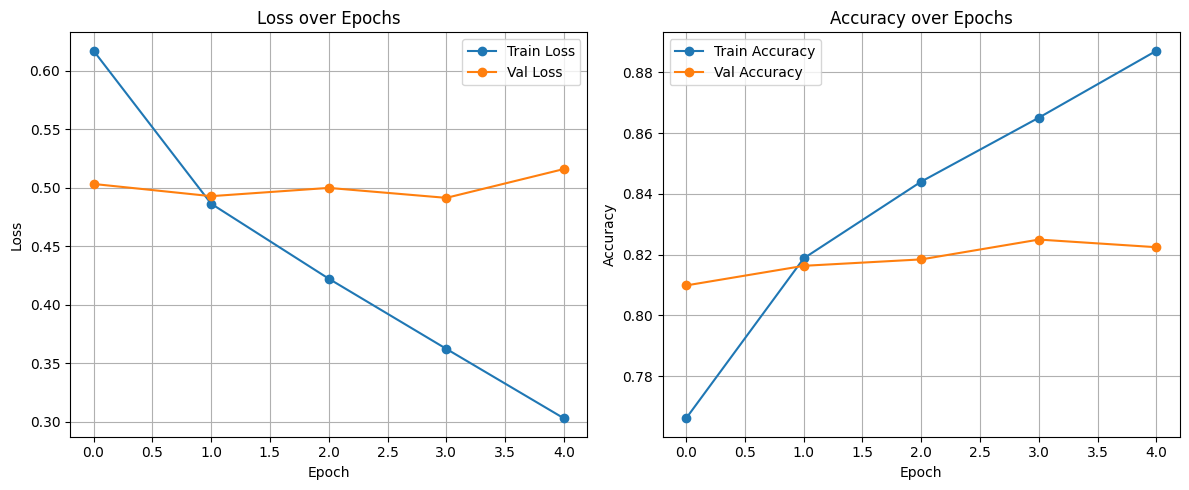

In [41]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_base['train_loss'], label='Train Loss', marker='o')
plt.plot(history_base['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_base['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history_base['val_acc'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [38]:
torch.save(model.state_dict(), 'base_model.pth')